# GEC Data Science Program
## Level 2: Lab 5

<div id="toc"><ul class="toc"><li><a href="#Working-with-Time-Series-Data">I. Working with Time Series Data</a><a class="anchor-link" href="#Working-with-Time-Series-Data">¶</a></li><ul class="toc"><li><a href="#Data%3A-Airline-Monthly-Traffic-Data">I. Data: Airline Monthly Traffic Data</a><a class="anchor-link" href="#Data:-Airline-Monthly-Traffic-Data">¶</a></li></ul><li><a href="#Q%3A-If-we-have-a-time-series-data%2C-how-can-we-predict-the-future-values%3F">II. Q: If we have a time series data, how can we predict the future values?</a><a class="anchor-link" href="#Q:-If-we-have-a-time-series-data,-how-can-we-predict-the-future-values?">¶</a></li><ul class="toc"><li><a href="#Q%3A-How-should-we-split-time-series-data-into-train-and-test-sets%3F">I. Q: How should we split time-series data into train and test sets?</a><a class="anchor-link" href="#Q:-How-should-we-split-time-series-data-into-train-and-test-sets?">¶</a></li></ul><li><a href="#Let's-train-a-simple-model-on-this-transformed-data%3A">III. Let's train a simple model on this transformed data:</a><a class="anchor-link" href="#Let's-train-a-simple-model-on-this-transformed-data:">¶</a></li></ul><li><a href="#Recurrent-Neural-Networks">II. Recurrent Neural Networks</a><a class="anchor-link" href="#Recurrent-Neural-Networks">¶</a></li><ul class="toc"><li><a href="#Long-Term-Short-Term-Memory-(LSTM)">I. Long-Term Short-Term Memory (LSTM)</a><a class="anchor-link" href="#Long-Term-Short-Term-Memory-(LSTM)">¶</a></li><ul class="toc"><li><a href="#LSTM-for-flight-data">I. LSTM for flight data</a><a class="anchor-link" href="#LSTM-for-flight-data">¶</a></li></ul><li><a href="#Q%3A-Is-it-over-fitted-or-under-fitted%3F-How-do-we-find-out%3F">II. Q: Is it over-fitted or under-fitted? How do we find out?</a><a class="anchor-link" href="#Q:-Is-it-over-fitted-or-under-fitted?-How-do-we-find-out?">¶</a></li><li><a href="#Let's-predict%3A">III. Let's predict:</a><a class="anchor-link" href="#Let's-predict:">¶</a></li><li><a href="#Stacking-multiple-LSTM-Layers">IV. Stacking multiple LSTM Layers</a><a class="anchor-link" href="#Stacking-multiple-LSTM-Layers">¶</a></li><li><a href="#Statefull-LSTM">V. Statefull LSTM</a><a class="anchor-link" href="#Statefull-LSTM">¶</a></li><ul class="toc"><li><a href="#Q%3A-Fix-the-error%3A">I. Q: Fix the error:</a><a class="anchor-link" href="#Q:-Fix-the-error:">¶</a></li><li><a href="#Q%3A-Fix-the-error%3A">II. Q: Fix the error:</a><a class="anchor-link" href="#Q:-Fix-the-error:">¶</a></li></ul><li><a href="#Transform-Time-Series-to-Stationary">VI. Transform Time Series to Stationary</a><a class="anchor-link" href="#Transform-Time-Series-to-Stationary">¶</a></li></ul><li><a href="#Video-classification-methods">III. Video classification methods</a><a class="anchor-link" href="#Video-classification-methods">¶</a></li></ul></ul></div>

### Working with Time Series Data

#### Data: Airline Monthly Traffic Data

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60

In [62]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 

In [63]:
import keras

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
%matplotlib inline
#import pandas
import matplotlib.pyplot as plt

In [67]:
def split_fit_predict(model, data, predictors, target, split_test_size=0.3):
    """
    1. Split 'data[predictors]','data[target] into train and test using 'split_test_size' ratio
    2. Fit 'model' using training data
    3. Predict against test data
    """
    if split_test_size == 0:
        df_train = data
        df_test = None
    else:
        df_train, df_test = train_test_split(data, test_size=split_test_size)
    X_train=df_train[predictors]
    X_test=df_test[predictors] if df_test else None
    y_train=df_train[target]
    y_test=df_test[target] if df_test else None
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test) if df_test else None
    y_fit=model.predict(X_train)
    return y_pred, y_test, y_fit

In [68]:
dataset = pd.read_csv('/Users/shahab/Downloads/international-airline-passengers.csv', 
                          index_col=0, skipfooter=3)

/Users/shahab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [70]:
dataset.columns=["passengers"]

In [71]:
dataset.head()

,passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [72]:
dataset.index=dataset.index.to_datetime()

/Users/shahab/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  """Entry point for launching an IPython kernel.


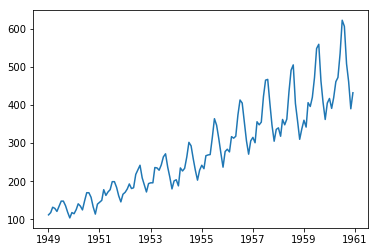

In [73]:
plt.plot(dataset);

In [74]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_n = scaler.fit_transform(dataset)

### Q: If we have a time series data, how can we predict the future values?

Let's say we have:
$t=[1, 2, 3, 4, 5, 6, 7, 8, 9]$

We can transform $t$ like this: 

For each value of $t$ we look at $n$ previous values (look-back), and create a feature matrix.

With look-back = 3:

$[1,2,3]->4$

$[2,3,4]->5$

$[3,4,5]->6$

$[4,5,6]->7$

$[5,6,7]->8$

$[6,7,8]->9$

$X=
\left(\begin{array}{cc} 
1 & 2 & 3\\
2 & 3 & 4\\
3 & 4 & 5\\
4 & 5 & 6\\
5 & 6 & 7\\
6 & 7 & 8\\
\end{array}\right)
$
$
y=\left(\begin{array}{cc}
4\\
5\\
6\\
7\\
8\\
9\\
\end{array}\right)
$

Now we can train a model using feature matrix $X$ and labels $y$. Then to predict the next value we use input vector $x=[7,8,9]$.

In [75]:
# convert an array of values into a look-back dataset matrix
def timeseries_to_matrix(timeseries, look_back=1):
    dataX, dataY = [], []
    for i in range(len(timeseries)-look_back):
        a = timeseries[i:(i+look_back)]
        dataX.append(a)
        dataY.append(timeseries[i + look_back])
    return np.array(dataX), np.array(dataY)

In [78]:
t=range(1,10)
timeseries_to_matrix(t,look_back=3)

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8]]), array([4, 5, 6, 7, 8, 9]))

In [79]:
look_back=5
X, y = timeseries_to_matrix(dataset_n[:,0], look_back)
#testX_r, testY_r = timeseries_to_matrix(test, look_back=5)

In [80]:
X

array([[ 0.01544402,  0.02702703,  0.05405405,  0.04826255,  0.03281853],
       [ 0.02702703,  0.05405405,  0.04826255,  0.03281853,  0.05984556],
       [ 0.05405405,  0.04826255,  0.03281853,  0.05984556,  0.08494208],
       [ 0.04826255,  0.03281853,  0.05984556,  0.08494208,  0.08494208],
       [ 0.03281853,  0.05984556,  0.08494208,  0.08494208,  0.06177606],
       [ 0.05984556,  0.08494208,  0.08494208,  0.06177606,  0.02895753],
       [ 0.08494208,  0.08494208,  0.06177606,  0.02895753,  0.        ],
       [ 0.08494208,  0.06177606,  0.02895753,  0.        ,  0.02702703],
       [ 0.06177606,  0.02895753,  0.        ,  0.02702703,  0.02123552],
       [ 0.02895753,  0.        ,  0.02702703,  0.02123552,  0.04247104],
       [ 0.        ,  0.02702703,  0.02123552,  0.04247104,  0.07142857],
       [ 0.02702703,  0.02123552,  0.04247104,  0.07142857,  0.05984556],
       [ 0.02123552,  0.04247104,  0.07142857,  0.05984556,  0.04054054],
       [ 0.04247104,  0.07142857,  0.0

#### Q: How should we split time-series data into train and test sets?

In [81]:
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size

In [83]:
train_size, test_size

(129, 15)

In [84]:
X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

In [85]:
X_train.shape, y_train.shape

((129, 5), (129,))

In [86]:
X_test.shape, y_test.shape

((10, 5), (10,))

Also create arrays for date-time values

In [89]:
dataset.shape

(144, 1)

In [87]:
T_train = dataset.index[look_back:train_size+look_back]
T_test = dataset.index[train_size+look_back:]

In [90]:
T_train.shape, T_test.shape

((129,), (10,))

### Let's train a simple model on this transformed data:

In [91]:
rf = RandomForestRegressor()
lr = LinearRegression()

In [92]:
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)
y_fit_rf=rf.predict(X_train)

In [93]:
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
y_fit_lr = lr.predict(X_train)

In [94]:
metrics.mean_squared_error(y_train, y_fit_rf)

0.00089727575675317467

In [95]:
metrics.mean_squared_error(y_test, y_pred_rf)

0.012457297893591329

In [96]:
metrics.mean_squared_error(y_train, y_fit_lr)

0.0029483213065468134

In [97]:
metrics.mean_squared_error(y_test, y_pred_lr)

0.0089503308167576505

In [98]:
# invert predictions
trainPredict = scaler.inverse_transform(y_fit_rf)
#trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(y_pred_rf)
#testY = scaler.inverse_transform([y_test])

/Users/shahab/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/shahab/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


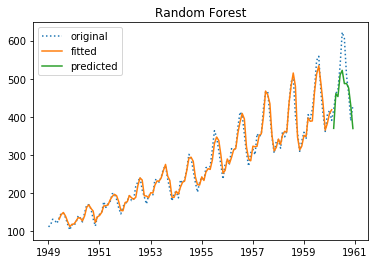

In [102]:
plt.plot(dataset,':')
plt.plot(T_train,trainPredict)
plt.plot(T_test, testPredict)
plt.legend(("original","fitted","predicted"))
plt.title("Random Forest")

In [103]:
# invert predictions
trainPredict_lr = scaler.inverse_transform(y_fit_lr)
testPredict_lr = scaler.inverse_transform(y_pred_lr)

/Users/shahab/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/shahab/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


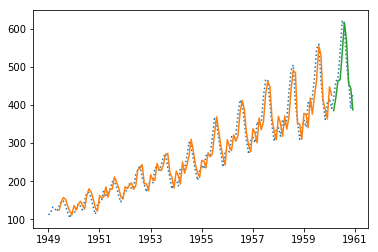

In [104]:
plt.plot(dataset,':')
plt.plot(T_train,trainPredict_lr)
plt.plot(T_test, testPredict_lr)

## Recurrent Neural Networks 
### Long-Term Short-Term Memory (LSTM)

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://keras.io/layers/recurrent/

http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

- Samples: These are independent observations from the domain, typically rows of data.

- Time steps: These are separate time steps of a given variable for a given observation.

- Features: These are separate measures observed at the time of observation.


In [105]:
data_dim = 16
timesteps = 8
num_classes = 10

In [106]:
# Generate dummy training data
x_train_toy = np.random.random((1000, timesteps, data_dim))
y_train_toy = np.random.random((1000, num_classes))

In [113]:
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, data_dim))) 
#timesteps can be passed as None and LSTM will calculate it
model.add(Dense(num_classes, activation='softmax'))

In [111]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [112]:
model.fit(x_train_toy,y_train_toy, epochs=2)

Epoch 1/2
1000/1000 [==============================] - 2s - loss: 11.5328 - acc: 0.1070     
Epoch 2/2
1000/1000 [==============================] - 1s - loss: 11.5247 - acc: 0.0930     


#### LSTM for flight data

In [114]:
X_train.shape

(129, 5)

In [119]:
# # reshape input to be [samples, time steps, features]
X_train_r = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_r = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [127]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(None,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [128]:
fitting=model.fit(X_train_r, y_train, nb_epoch=100, batch_size=5, verbose=1, 
                  validation_split=0.2)

Train on 103 samples, validate on 26 samples
Epoch 1/100
103/103 [==============================] - 1s - loss: 0.1053 - val_loss: 0.3862
Epoch 2/100
103/103 [==============================] - 0s - loss: 0.0775 - val_loss: 0.3033
Epoch 3/100
103/103 [==============================] - 0s - loss: 0.0563 - val_loss: 0.2337
Epoch 4/100
103/103 [==============================] - 0s - loss: 0.0404 - val_loss: 0.1782
Epoch 5/100
103/103 [==============================] - 0s - loss: 0.0284 - val_loss: 0.1320
Epoch 6/100
103/103 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0974
Epoch 7/100
103/103 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0682
Epoch 8/100
103/103 [==============================] - 0s - loss: 0.0125 - val_loss: 0.0511
Epoch 9/100
103/103 [==============================] - 0s - loss: 0.0112 - val_loss: 0.0403
Epoch 10/100
103/103 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0344
Epoch 11/100
103/103 [============

103/103 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0099
Epoch 89/100
103/103 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0100
Epoch 90/100
103/103 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0096
Epoch 91/100
103/103 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0095
Epoch 92/100
103/103 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0096
Epoch 93/100
103/103 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0093
Epoch 94/100
103/103 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0093
Epoch 95/100
103/103 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0093
Epoch 96/100
103/103 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0092
Epoch 97/100
103/103 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0092
Epoch 98/100
103/103 [==============================] - 0s - loss: 0.0031 - val_los

### Q: Is it over-fitted or under-fitted? How do we find out?

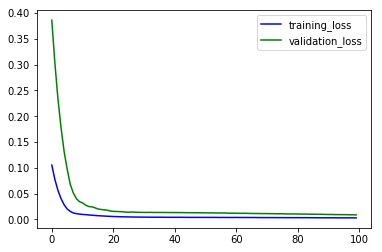

In [130]:
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'g')
plt.legend(('training_loss', 'validation_loss'))

### Let's predict:

In [131]:
y_fit_lstm=model.predict(X_train_r)
y_pred_lstm=model.predict(X_test_r)

trainPredict_lstm = scaler.inverse_transform(y_fit_lstm)
testPredict_lstm = scaler.inverse_transform(y_pred_lstm)

In [132]:
trainPredict_lstm.shape, testPredict_lstm.shape

((129, 1), (10, 1))

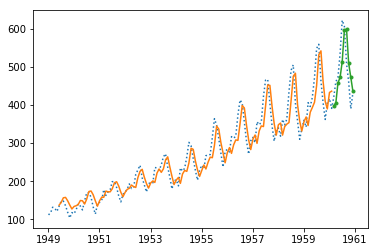

In [133]:
plt.plot(dataset,':')
plt.plot(T_train,trainPredict_lstm)
plt.plot(T_test, testPredict_lstm,'.-')

In [134]:
metrics.mean_squared_error(y_train,y_fit_lstm)

0.0040600830945994792

In [135]:
metrics.mean_squared_error(y_test,y_pred_lstm)

0.013760623977365946

### Stacking multiple LSTM Layers

You should use return_sequences=True

In [136]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, 
               input_shape=(None, look_back)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',
             metrics=['mean_squared_error'])

In [144]:
fitting=model.fit(X_train_r, y_train, nb_epoch=150, batch_size=5, verbose=1, 
                  validation_split=0.1)

Train on 116 samples, validate on 13 samples
Epoch 1/150
116/116 [==============================] - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 2/150
116/116 [==============================] - 0s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 3/150
116/116 [==============================] - 0s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 4/150
116/116 [==============================] - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/150
116/116 [==============================] - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 6/150
116/116 [==============================] - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 7/150
116/116 [==========

116/116 [==============================] - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 54/150
116/116 [==============================] - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 55/150
116/116 [==============================] - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 56/150
116/116 [==============================] - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 57/150
116/116 [==============================] - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 58/150
116/116 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 59/150
116/116 [==============================] - 0s - loss: 0.0027 - mean_sq

116/116 [==============================] - 0s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 106/150
116/116 [==============================] - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 107/150
116/116 [==============================] - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 108/150
116/116 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 109/150
116/116 [==============================] - 0s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 110/150
116/116 [==============================] - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 111/150
116/116 [==============================] - 0s - loss: 0.0026 - m

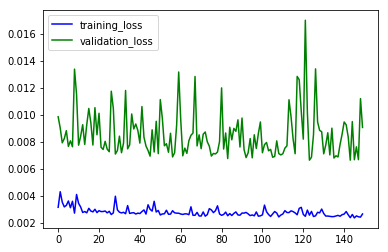

In [145]:
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'g')
plt.legend(('training_loss', 'validation_loss'))

In [146]:
y_fit_lstm=model.predict(X_train_r)
y_pred_lstm=model.predict(X_test_r)

trainPredict_lstm = scaler.inverse_transform(y_fit_lstm)
testPredict_lstm = scaler.inverse_transform(y_pred_lstm)

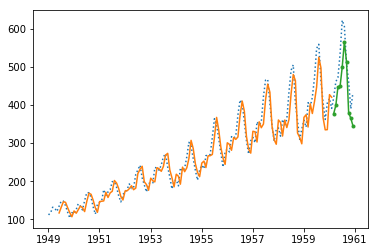

In [147]:
plt.plot(dataset,':')
plt.plot(T_train,trainPredict_lstm)
plt.plot(T_test, testPredict_lstm,'.-')

In [148]:
metrics.mean_squared_error(y_train,y_fit_lstm)

0.0030904849731367675

In [149]:
metrics.mean_squared_error(y_test,y_pred_lstm)

0.016752519562584885

### Statefull LSTM

A stateful recurrent model is one for which the internal states (memories) obtained after processing a batch of samples are reused as initial states for the samples of the next batch. This allows to process longer sequences while keeping computational complexity manageable.

In [150]:
batch_size=10

#### Q: Fix the error:

In [152]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, stateful=True,
               #input_shape=(None, look_back)))  
               batch_input_shape=(batch_size, None, look_back)))
model.add(LSTM(32, return_sequences=True, stateful=True))  
model.add(LSTM(32, stateful=True))  
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',
             metrics=['mean_squared_error'])

In [156]:
X_train_r.shape[0]/batch_size

12.9

#### Q: Fix the error:

In [157]:
fitting=model.fit(X_train_r[-12*batch_size:], y_train[-12*batch_size:], 
                  nb_epoch=100, batch_size=batch_size, verbose=1, validation_split=0.25)

Train on 90 samples, validate on 30 samples
Epoch 1/100
90/90 [==============================] - 3s - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.1357 - val_mean_squared_error: 0.1357
Epoch 2/100
90/90 [==============================] - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0580 - val_mean_squared_error: 0.0580
Epoch 3/100
90/90 [==============================] - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.1971 - val_mean_squared_error: 0.1971
Epoch 4/100
90/90 [==============================] - 0s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.1460 - val_mean_squared_error: 0.1460
Epoch 5/100
90/90 [==============================] - 0s - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 6/100
90/90 [==============================] - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.1026 - val_mean_squared_error: 0.1026
Epoch 7/100
90/90 [=========================

90/90 [==============================] - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 54/100
90/90 [==============================] - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 55/100
90/90 [==============================] - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 56/100
90/90 [==============================] - 0s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 57/100
90/90 [==============================] - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 58/100
90/90 [==============================] - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 59/100
90/90 [==============================] - 0s - loss: 0.0055 - mean_squared_error: 0

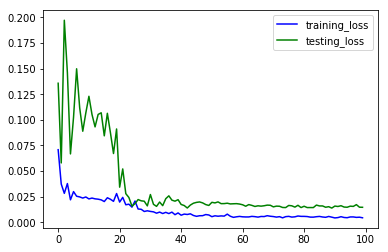

In [158]:
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'g')
plt.legend(('training_loss', 'testing_loss'))

In [159]:
X_test_r.shape[0] / batch_size

1.0

In [160]:
y_fit_lstm=model.predict(X_train_r[-12*batch_size:], batch_size=batch_size)
y_pred_lstm=model.predict(X_test_r)

trainPredict_lstm = scaler.inverse_transform(y_fit_lstm)
testPredict_lstm = scaler.inverse_transform(y_pred_lstm)

In [161]:
len(trainPredict_lstm)

120

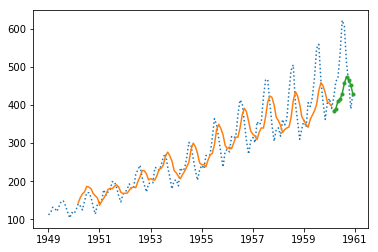

In [162]:
plt.plot(dataset,':')
plt.plot(T_train[9:],trainPredict_lstm)
plt.plot(T_test, testPredict_lstm,'.-')

In [164]:
metrics.mean_squared_error(y_train[-12*batch_size:],y_fit_lstm)

0.0074718977091674486

In [165]:
metrics.mean_squared_error(y_test,y_pred_lstm)

0.032897964451051871

This is unerfitted. Let's add more epochs and early stopping.

In [166]:
from keras import callbacks

In [167]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, stateful=True,
               #input_shape=(None, look_back)))  # returns a sequence of vectors of dimension 32
                batch_input_shape=(batch_size, None, look_back)))
model.add(LSTM(30, return_sequences=True, stateful=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(20, stateful=True))  # return a single vector of dimension 32
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',
             metrics=['mean_squared_error'])

In [170]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
fitting=model.fit(X_train_r[-12*batch_size:], y_train[-12*batch_size:], callbacks=[early_stopping],
                  nb_epoch=1000, batch_size=batch_size, verbose=1, validation_split=0.25,)

Train on 90 samples, validate on 30 samples
Epoch 1/1000
90/90 [==============================] - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 2/1000
90/90 [==============================] - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 3/1000
90/90 [==============================] - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 4/1000
90/90 [==============================] - 0s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 5/1000
90/90 [==============================] - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 6/1000
90/90 [==============================] - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 7/1000
90/90 [==================

90/90 [==============================] - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 54/1000
90/90 [==============================] - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 55/1000
90/90 [==============================] - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 56/1000
90/90 [==============================] - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 57/1000
90/90 [==============================] - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0143 - val_mean_squared_error: 0.0143.
Epoch 58/1000
90/90 [==============================] - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 59/1000
90/90 [==============================] - 0s - loss: 0.0040 - mean_squared_e

90/90 [==============================] - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 106/1000
90/90 [==============================] - 0s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 107/1000
90/90 [==============================] - 0s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 108/1000
90/90 [==============================] - 0s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 109/1000
90/90 [==============================] - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 110/1000
90/90 [==============================] - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 111/1000
90/90 [==============================] - 0s - loss: 0.0043 - mean_squa

90/90 [==============================] - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 158/1000
90/90 [==============================] - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 159/1000
90/90 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 160/1000
90/90 [==============================] - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 161/1000
90/90 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 162/1000
90/90 [==============================] - 0s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 163/1000
90/90 [==============================] - 0s - loss: 0.0036 - mean_squa

90/90 [==============================] - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 209/1000
90/90 [==============================] - 0s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 210/1000
90/90 [==============================] - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 211/1000
90/90 [==============================] - 0s - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 212/1000
90/90 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 213/1000
90/90 [==============================] - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 214/1000
90/90 [==============================] - 0s - loss: 0.0035 - mean_squa

90/90 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 261/1000
90/90 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 262/1000
90/90 [==============================] - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 263/1000
90/90 [==============================] - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 264/1000
90/90 [==============================] - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 265/1000
90/90 [==============================] - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 266/1000
90/90 [==============================] - 0s - loss: 0.0028 - mean_squa

90/90 [==============================] - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 313/1000
90/90 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 314/1000
90/90 [==============================] - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 315/1000
90/90 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 316/1000
90/90 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 317/1000
90/90 [==============================] - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 318/1000
90/90 [==============================] - 0s - loss: 0.0027 - mean_squa

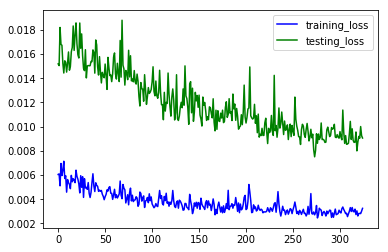

In [172]:
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'g')
plt.legend(('training_loss', 'testing_loss'))

In [173]:
y_fit_lstm=model.predict(X_train_r[-12*batch_size:], batch_size=batch_size)
y_pred_lstm=model.predict(X_test_r)

trainPredict_lstm = scaler.inverse_transform(y_fit_lstm)
testPredict_lstm = scaler.inverse_transform(y_pred_lstm)

In [174]:
metrics.mean_squared_error(y_train[-12*batch_size:],y_fit_lstm)

0.0048741291579757233

In [175]:
metrics.mean_squared_error(y_test,y_pred_lstm)

0.019693029837029717

### Transform Time Series to Stationary

In [176]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff, dtype=np.float)

In [178]:
# def inverse_difference(history, yhat, interval=1):
#     return yhat + history[-interval]

In [179]:
def inverse_difference(t0, differenced):
    inverted=[t0]
    for d in differenced:
        inverted.append(inverted[-1]+d)
    inverted=np.array(inverted)
    return inverted

In [180]:
dataset.head()

,passengers
1949-01-04,112
1949-02-04,118
1949-03-04,132
1949-04-04,129
1949-05-04,121


In [181]:
differenced = difference(dataset.values, 1)
print(differenced)

[[   6.]
 [  14.]
 [  -3.]
 [  -8.]
 [  14.]
 [  13.]
 [   0.]
 [ -12.]
 [ -17.]
 [ -15.]
 [  14.]
 [  -3.]
 [  11.]
 [  15.]
 [  -6.]
 [ -10.]
 [  24.]
 [  21.]
 [   0.]
 [ -12.]
 [ -25.]
 [ -19.]
 [  26.]
 [   5.]
 [   5.]
 [  28.]
 [ -15.]
 [   9.]
 [   6.]
 [  21.]
 [   0.]
 [ -15.]
 [ -22.]
 [ -16.]
 [  20.]
 [   5.]
 [   9.]
 [  13.]
 [ -12.]
 [   2.]
 [  35.]
 [  12.]
 [  12.]
 [ -33.]
 [ -18.]
 [ -19.]
 [  22.]
 [   2.]
 [   0.]
 [  40.]
 [  -1.]
 [  -6.]
 [  14.]
 [  21.]
 [   8.]
 [ -35.]
 [ -26.]
 [ -31.]
 [  21.]
 [   3.]
 [ -16.]
 [  47.]
 [  -8.]
 [   7.]
 [  30.]
 [  38.]
 [  -9.]
 [ -34.]
 [ -30.]
 [ -26.]
 [  26.]
 [  13.]
 [  -9.]
 [  34.]
 [   2.]
 [   1.]
 [  45.]
 [  49.]
 [ -17.]
 [ -35.]
 [ -38.]
 [ -37.]
 [  41.]
 [   6.]
 [  -7.]
 [  40.]
 [  -4.]
 [   5.]
 [  56.]
 [  39.]
 [  -8.]
 [ -50.]
 [ -49.]
 [ -35.]
 [  35.]
 [   9.]
 [ -14.]
 [  55.]
 [  -8.]
 [   7.]
 [  67.]
 [  43.]
 [   2.]
 [ -63.]
 [ -57.]
 [ -42.]
 [  31.]
 [   4.]
 [ -22.]
 [  44.]
 [ -14.]
 

Inverse transform is easy using the first value.

In [182]:
t0=dataset.values[0]
inverted=[t0]
for d in differenced:
    inverted.append(inverted[-1]+d)
inverted=np.array(inverted)

In [183]:
all(inverted==dataset.values)

True

In [184]:
differenced_n = scaler.fit_transform(differenced)
look_back=5
X, y = timeseries_to_matrix(dataset_n[:,0], look_back)
dX, dy = timeseries_to_matrix(differenced_n[:,0], look_back)

dX_train = dX[:train_size]
dX_test = dX[train_size:]

dy_train = dy[:train_size]
dy_test = dy[train_size:]

X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

In [185]:
dX.shape, dX_train.shape, dX_test.shape

((138, 5), (129, 5), (9, 5))

In [186]:
dX_train_r = np.reshape(dX_train, (dX_train.shape[0], 1, dX_train.shape[1]))
dX_test_r = np.reshape(dX_test, (dX_test.shape[0], 1, dX_test.shape[1]))

In [187]:
model = Sequential()
model.add(LSTM(20, input_shape=(None,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [188]:
fitting=model.fit(dX_train_r, dy_train, nb_epoch=200, batch_size=10, verbose=1, validation_split=0.2)

Train on 103 samples, validate on 26 samples
Epoch 1/200
103/103 [==============================] - 2s - loss: 0.2110 - mean_squared_error: 0.2110 - val_loss: 0.2221 - val_mean_squared_error: 0.2221
Epoch 2/200
103/103 [==============================] - 0s - loss: 0.1462 - mean_squared_error: 0.1462 - val_loss: 0.1669 - val_mean_squared_error: 0.1669
Epoch 3/200
103/103 [==============================] - 0s - loss: 0.0976 - mean_squared_error: 0.0976 - val_loss: 0.1254 - val_mean_squared_error: 0.1254
Epoch 4/200
103/103 [==============================] - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0985 - val_mean_squared_error: 0.0985
Epoch 5/200
103/103 [==============================] - 0s - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0827 - val_mean_squared_error: 0.0827
Epoch 6/200
103/103 [==============================] - 0s - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0756 - val_mean_squared_error: 0.0756
Epoch 7/200
103/103 [==========

103/103 [==============================] - 0s - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 54/200
103/103 [==============================] - 0s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Epoch 55/200
103/103 [==============================] - 0s - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 56/200
103/103 [==============================] - 0s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 57/200
103/103 [==============================] - 0s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0606 - val_mean_squared_error: 0.0606
Epoch 58/200
103/103 [==============================] - 0s - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0603 - val_mean_squared_error: 0.0603
Epoch 59/200
103/103 [==============================] - 0s - loss: 0.0189 - mean_sq

103/103 [==============================] - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0519 - val_mean_squared_error: 0.0519
Epoch 106/200
103/103 [==============================] - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 107/200
103/103 [==============================] - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 108/200
103/103 [==============================] - 0s - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 109/200
103/103 [==============================] - 0s - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 110/200
103/103 [==============================] - 0s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 111/200
103/103 [==============================] - 0s - loss: 0.0156 - m

103/103 [==============================] - 0s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 158/200
103/103 [==============================] - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 159/200
103/103 [==============================] - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0500 - val_mean_squared_error: 0.0500
Epoch 160/200
103/103 [==============================] - 0s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 161/200
103/103 [==============================] - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 162/200
103/103 [==============================] - 0s - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 163/200
103/103 [==============================] - 0s - loss: 0.0151 - m

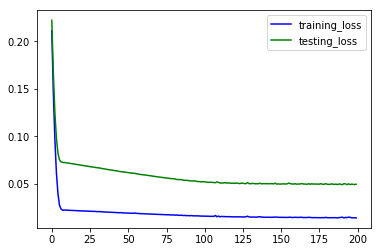

In [189]:
plt.plot(fitting.history['loss'],'b')
plt.plot(fitting.history['val_loss'],'g')
plt.legend(('training_loss', 'testing_loss'))

In [190]:
dy_fit_lstm=model.predict(dX_train_r)
dy_pred_lstm=model.predict(dX_test_r)

dtrainPredict_lstm = scaler.inverse_transform(dy_fit_lstm)
dtestPredict_lstm = scaler.inverse_transform(dy_pred_lstm)

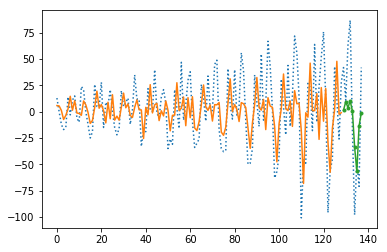

In [191]:
plt.plot(differenced[look_back:],':')
plt.plot(dtrainPredict_lstm)
plt.plot(range(len(dtrainPredict_lstm),len(differenced)-look_back),dtestPredict_lstm,'.-')

In [192]:
metrics.mean_squared_error(dy_train,dy_fit_lstm)

0.021591777470381528

In [193]:
metrics.mean_squared_error(dy_test,dy_pred_lstm)

0.065080235664214489

## Video classification methods

1. Classifying one frame at a time with a ConvNet
2. Using a time-distributed ConvNet and passing the features to an RNN(LSTM), in one network
3. Using a 3D convolutional network
4. Extracting features from each frame with a ConvNet and passing the sequence to a separate LSTM
5. Extracting features from each frame with a ConvNet and passing the sequence to a separate MLP

https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5

https://github.com/harvitronix/five-video-classification-methods/blob/master/models.py

The best method is #4: CNN+LSTM